
# Geoherb identification

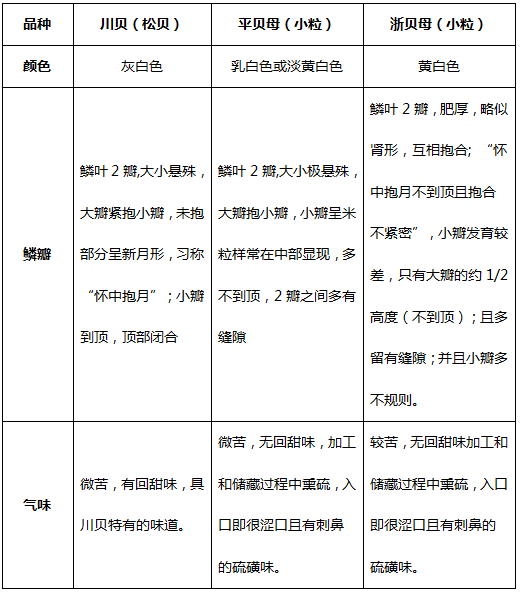

# Load Data

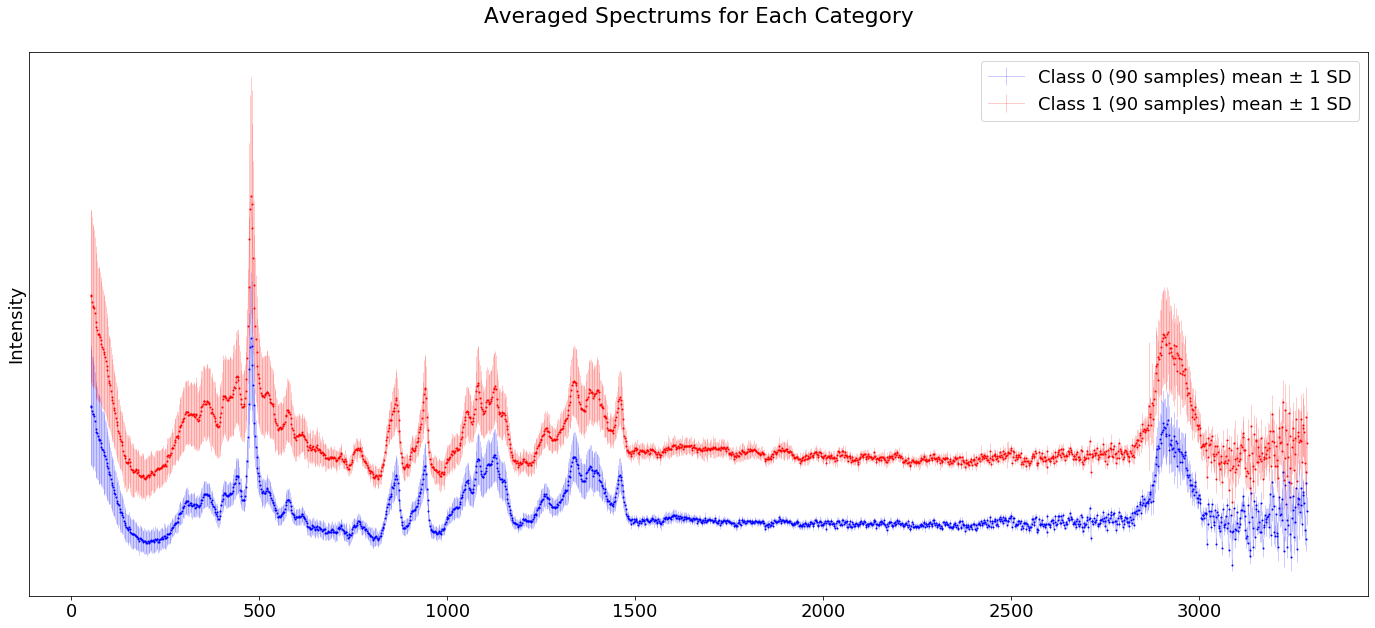

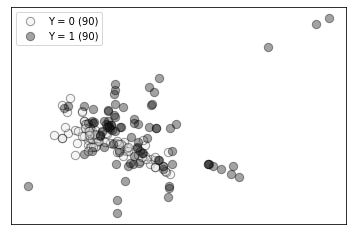

Data Set ID: 754a 川贝母、浙贝母拉曼光谱

["川贝母","浙贝母"] 90 samples per class

COLLECTION AND PROCESSING INFORMATION
Title: Position X =-12643 Y = 6208, Signal to noise ratio =24.6
Collected: Wed Mar 23 14:18:22 2022 (GMT+08:00)
Filename: C:\my documents\omnic\GFJ\20220323\chuanbeimu9 23-3-2022 14-9-54.CSV
Comments: 
Custom info 1: 
Custom info 2: 
DATA DESCRIPTION
 Number of points: 1682
 X-axis: Raman shift (cm-1)
 Y-axis: Raman intensity
 First X value: 49.6820
 Last X value: 3291.4346
 Raman laser frequency: 12738.9932
 Data spacing: 1.928467
DATA COLLECTION INFORMATION
 Exposure time: 0.1429 sec
 Number of exposures: 600
 Number of background exposures: 600
SPECTROMETER DESCRIPTION
 Spectrometer: DXR Raman Microscope
 Bench serial number: AXX1916142
 Laser: 785 nm
 Laser serial number: BAB1910322
 Laser power level: 19.0 mW
 Filter: 785 nm
 Filter serial number: BAL1910361
 Grating: 400 lines/mm
 Grating serial number: BAC1910373
 Spectrograph aperture: 50 µm pinhole
 Camera at temperature




In [1]:
from qsi import io
X,y,X_names,desc = io.LoadDataSet('beimu')

# Preprocessing


## Feature Scaling

As the kernels are actually pair-wise distances, we highly recommend do feature scaling.  Otherwise, the high-value features will have dominating effect.

In [2]:
# normalization
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

# scaling to [0,1]
from sklearn.preprocessing import MinMaxScaler

mm_scaler = MinMaxScaler()
X_mm_scaled = mm_scaler.fit_transform(X)

score =  0.448


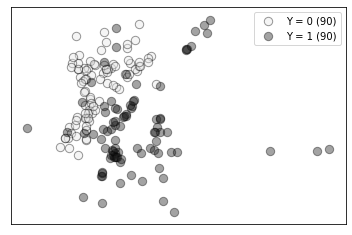

In [3]:
from qsi.vis import *
from sklearn.cross_decomposition import PLSRegression

pls = PLSRegression(n_components=2, scale = False)
X_pls = pls.fit(X, y).transform(X)

plotComponents2D(X_pls, y) # , tags = range(len(y)), ax = ax
print('score = ', np.round(pls.score(X, y),3)) # Returns the coefficient of determination R^2 of the prediction.

# knnrw

knnrw = NNRW + Multiple Kernel Learning

### Mercer 定理

任何半正定的函数都可以作为核函数。所谓半正定的函数f(xi,xj)，是指拥有训练数据集合（x1,x2,...xn)，我们定义一个矩阵的元素aij = f(xi,xj)，这个矩阵式n*n的，如果这个矩阵是半正定的，那么f(xi,xj)就称为半正定的函数。这个mercer定理不是核函数必要条件，只是一个充分条件，即还有不满足mercer定理的函数也可以是核函数

# knnrw provides three flavors: 

### flavor = 'sum'

不包含权重或偏置参数的初始化，实为将原始特征转化为一个线性核变换(Gram Matrix)与若干非线性核变换的叠加，得到一个mxm的SumMatrix。模型本身为单层NN

### flavor = 'stack'

拼接为一个大矩阵 [Gram, rbf, sigmoid, ...]，尺寸为m x km。k为拼接的kernel数量

### flavor = 'sum + stack'

拼接为一个大矩阵 [SumMatrix, Gram, rbf, sigmoid, ...]，尺寸为m x (k+1)m。k为拼接的kernel数量

# Install

We have published relavent codes on GitHub: https://github.com/zhangys11/pyNNRW  
The package is published on the PyPi repository and can be installed in python via command: ` pip install pyNNRW==0.2.3 `

# Parameter tuning for each kernel

The Raman data is very high-dimensional. We first check individual kernels to get an optimal param on the domain data.

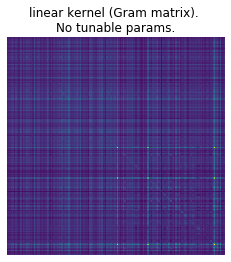

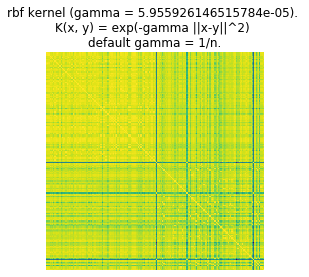

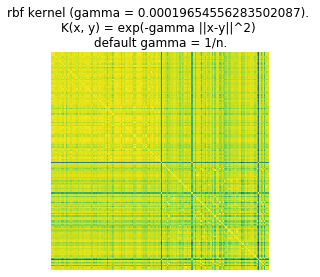

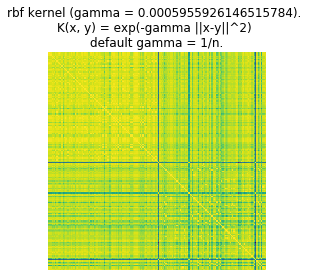

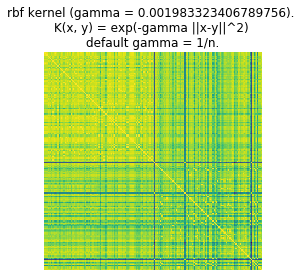

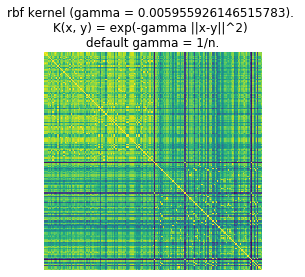

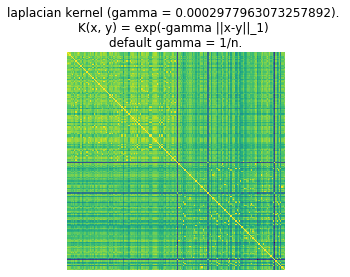

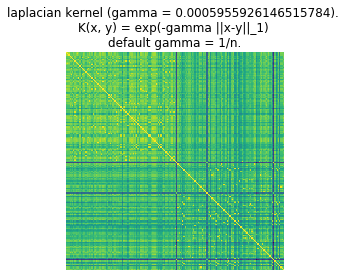

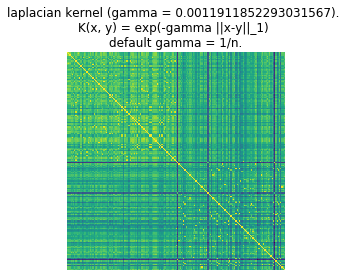

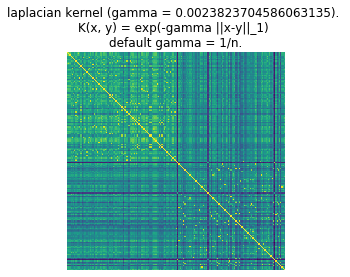

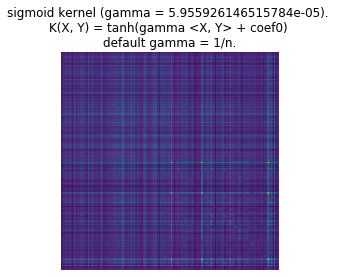

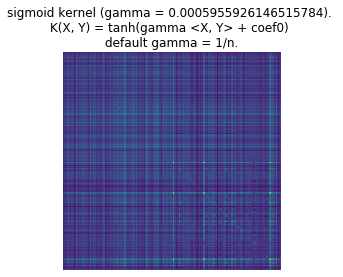

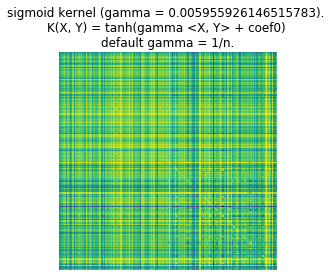

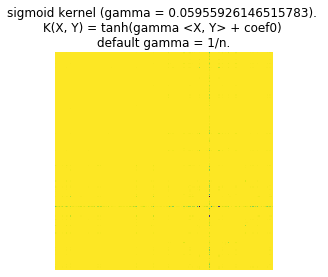

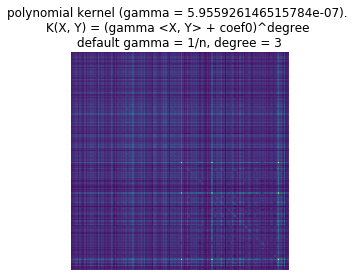

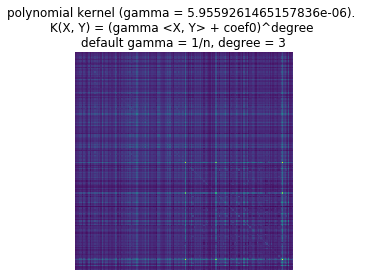

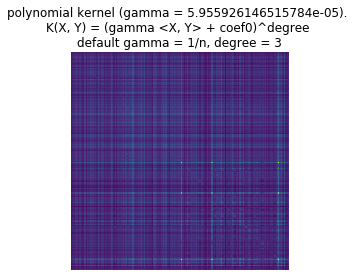

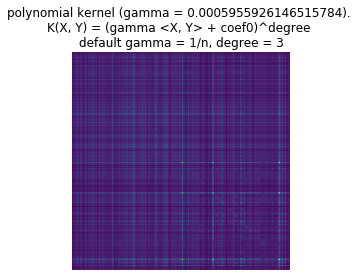

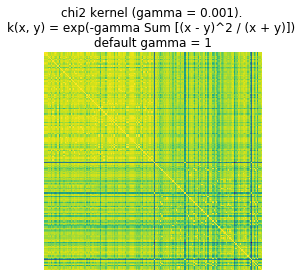

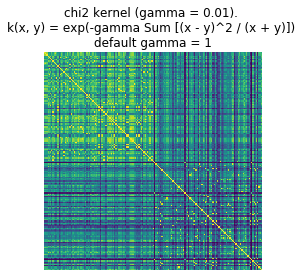

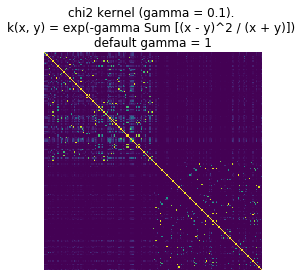

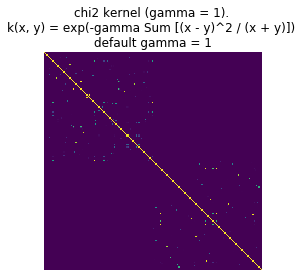

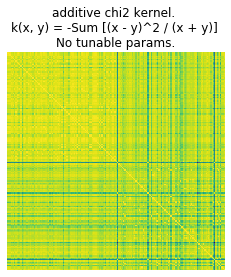

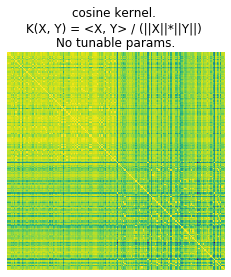

In [5]:
from qsi.cla.kernel import *
KernelTuning(X_mm_scaled)

Because the first and last half samples belong to two classes respectively. We want to get a contrasive pattern, i.e., (左上、右下) 与 （左下、右上）差别大。

linear kernel所生产的Gram Matrix 和 poly kernel (需要gamma非常小，才能显示出一定的pattern) 不能很好区分高维拉曼的样本距离. additive chi2 pattern较弱，其余kernel在特定param取值下pattern明显

# Grid Search for the best kernel combination

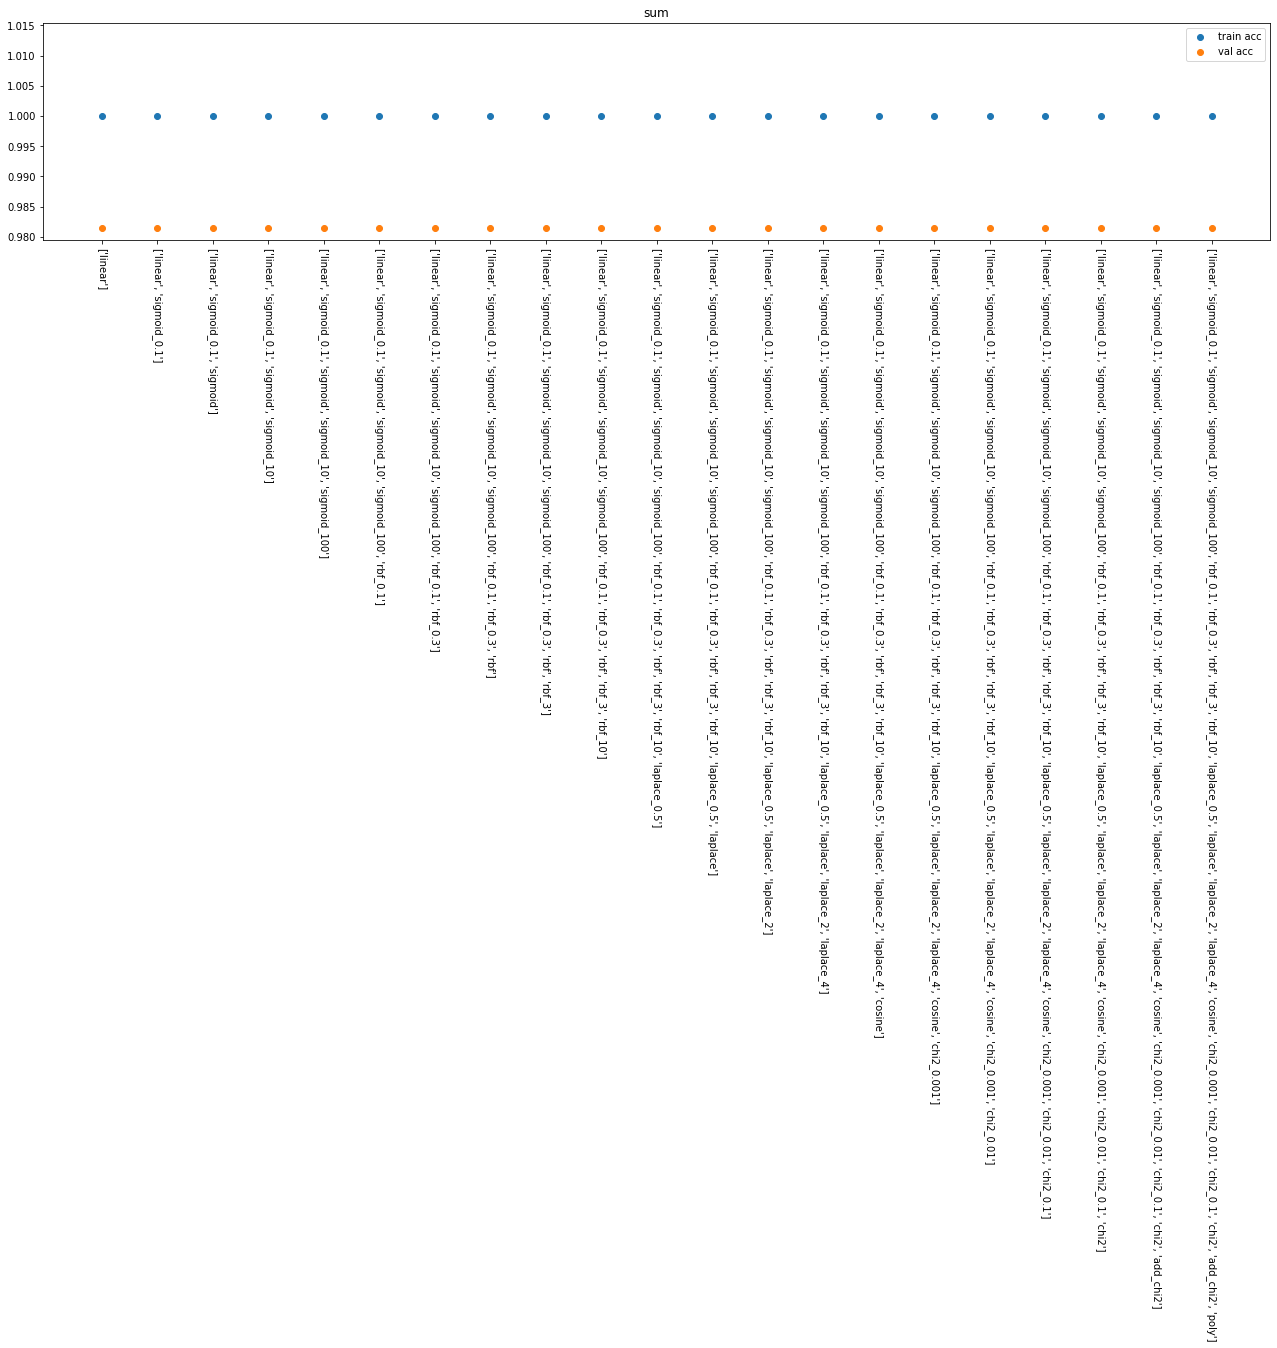

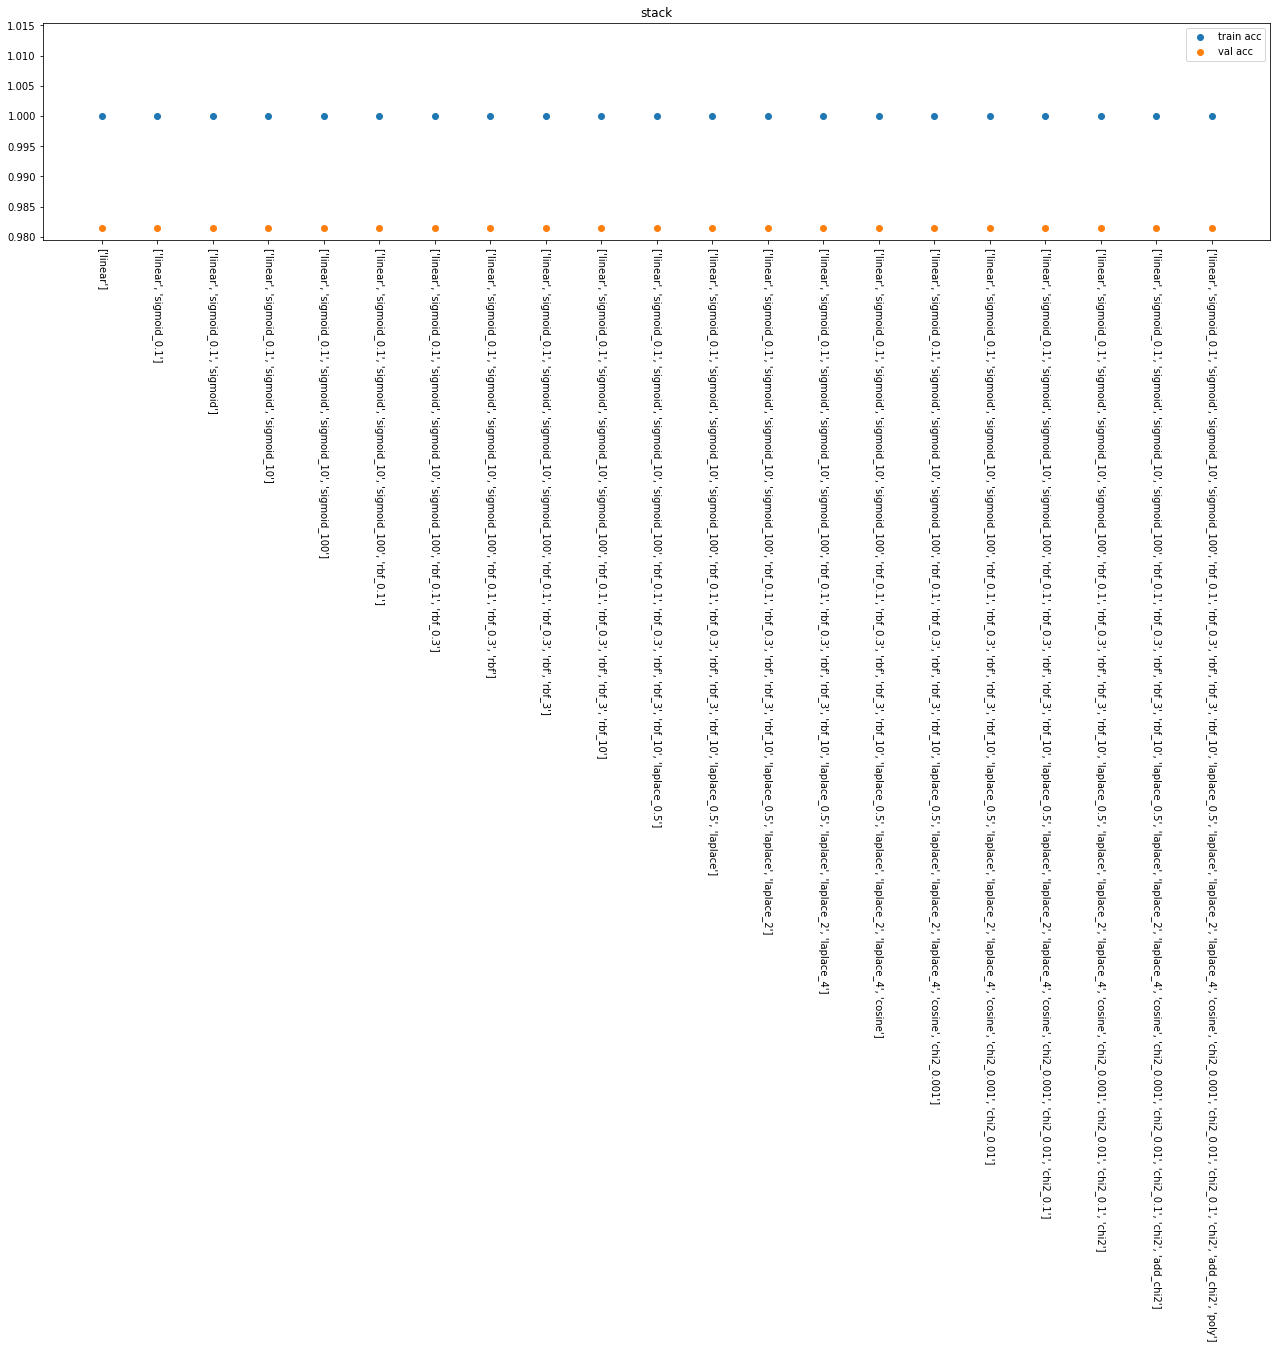

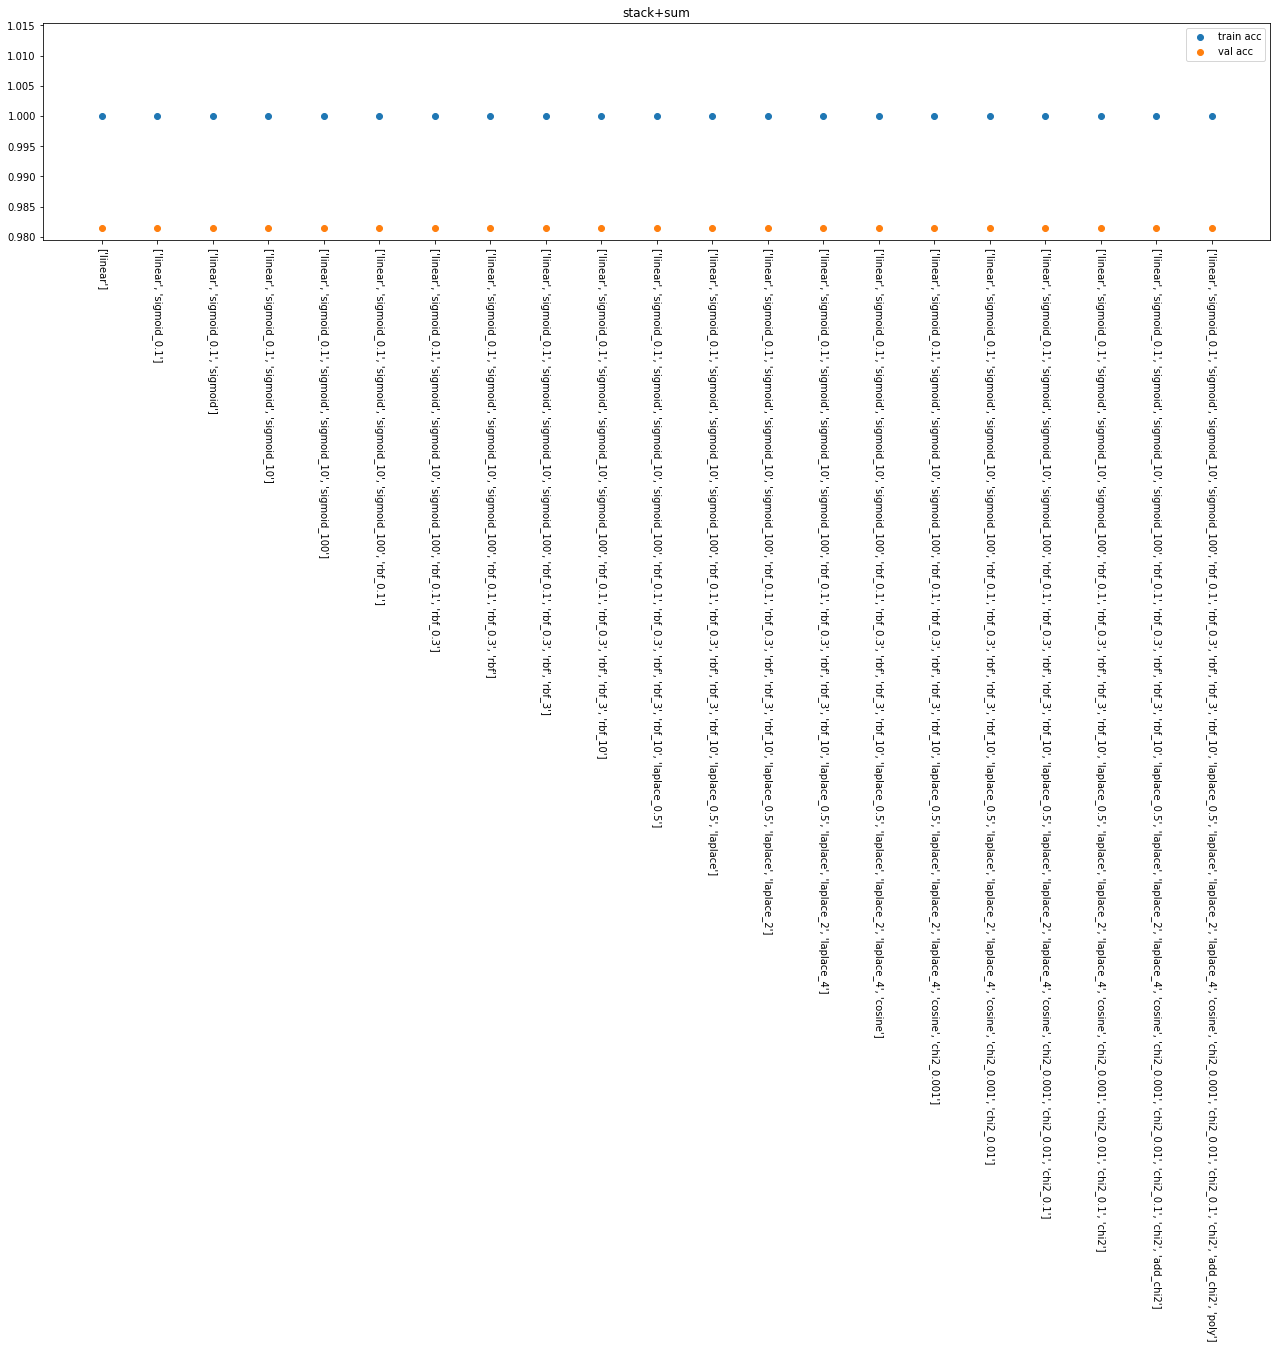

In [7]:
from sklearn.model_selection import train_test_split

x_train, x_test, t_train, t_test = train_test_split(X_mm_scaled, y, test_size=0.3)
_ = KNNRWGridSearch(x_train, x_test, t_train, t_test, verbose = False)

# Performance comparison. Define a wrapper (use callback function parameter), which calls each specific classifier

Due to inherent randomness (e.g., random initialization), some algorithms (e.g., NNRW, MLP) have slightly different results for each run. 

# A. NNRW - ELM

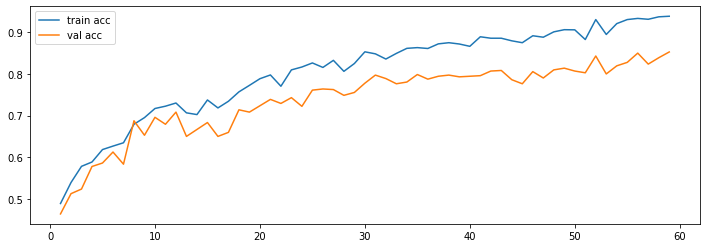

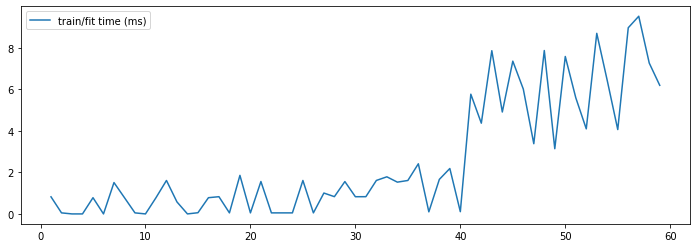

In [14]:
from qsi.cla.ensemble import *

MTacc, MVacc, MT = PerformenceTests(ELMClf, X, y, Ls = list(range(1, 60)))

In [15]:
IDX = 30
print('Mean Train Acc = ', MTacc[IDX], ' Mean Test Acc = ', MVacc[IDX], ' Mean Consumed Time = ', MT[IDX])

Mean Train Acc =  0.8482638888888889  Mean Test Acc =  0.7972222222222223  Mean Consumed Time =  0.8299949999999999


# B. MLP

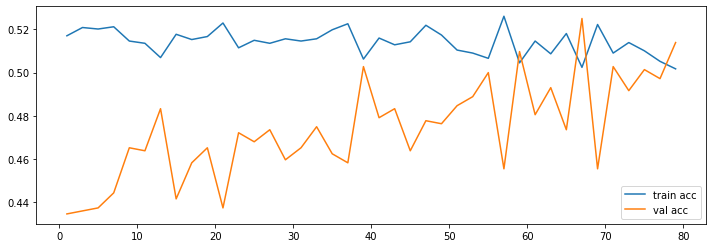

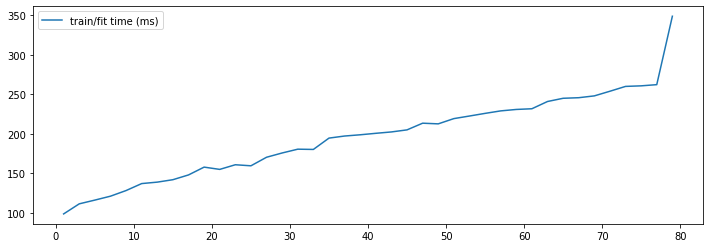

In [16]:
MTacc, MVacc, MT = PerformenceTests(MLPClf, X, y, Ls = list(range(1, 80, 2)))

In [13]:
IDX = 20
print('Mean Train Acc = ', MTacc[IDX], ' Mean Test Acc = ', MVacc[IDX], ' Mean Consumed Time = ', MT[IDX])

Mean Train Acc =  0.5135416666666667  Mean Test Acc =  0.46527777777777785  Mean Consumed Time =  194.59754000000004


# C. rbf-SVM

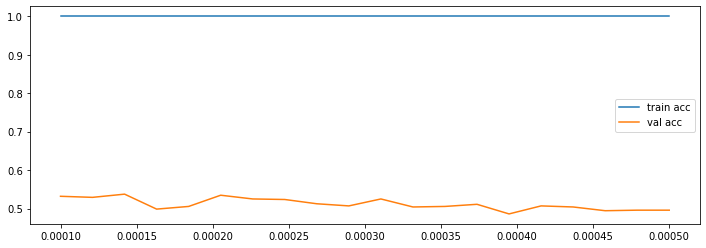

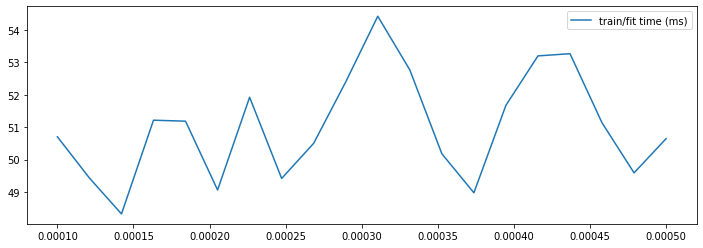

gamma = 1/(2σ^2)


In [17]:
MTacc, MVacc, MT = PerformenceTests(SVMClf, X, y, Ls = np.linspace(0.0001,0.0005,20).tolist())
print("gamma = 1/(2σ^2)")

In [18]:
IDX = 10 
print('Mean Train Acc = ', MTacc[IDX], ' Mean Test Acc = ', MVacc[IDX], ' Mean Consumed Time = ', MT[IDX])

Mean Train Acc =  1.0  Mean Test Acc =  0.525  Mean Consumed Time =  54.423474999999996


# D. Decision Tree

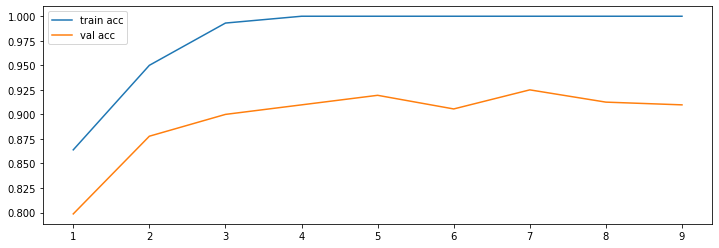

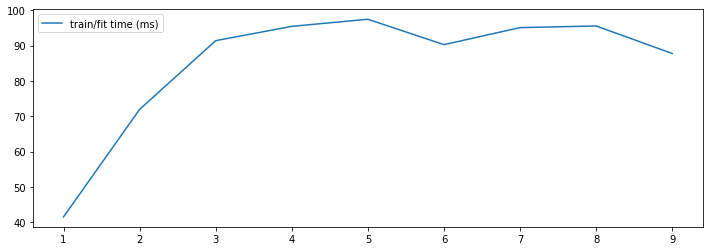

In [19]:
MTacc, MVacc, MT = PerformenceTests(TreeClf, X, y, Ls = list(range(1,10))) # here we use ys to gurantee it is multi-class, not regression

In [20]:
IDX = 2  # best depth 3
print('Mean Train Acc = ', MTacc[IDX], ' Mean Test Acc = ', MVacc[IDX], ' Mean Consumed Time = ', MT[IDX])

Mean Train Acc =  0.9930555555555557  Mean Test Acc =  0.8999999999999997  Mean Consumed Time =  91.44914


# Appendix

### Raman Interpretation

<table>
    <thead>
        <tr class="text-center">
            <th>Wavenumber (cm-1)</th>
            <th>Raman Shift Interpretation</th>
        </tr>
    </thead>
    <tbody><tr>
                <td>1748</td>
                <td>C=O伸缩振动，主要可能源自于脂肪有关的酯基</td>
            </tr>
            <tr>
                <td>1663</td>
                <td>C=O伸缩振动和C=C伸缩振动，其中C=O伸缩振动可能主要源自于蛋白质的酰胺I键，C=C伸缩振动主要源自于不饱和脂肪酸</td>
            </tr>
            <tr>
                <td>1465</td>
                <td>CH2变形振动，可能主要源自于糖类和脂肪分子</td>
            </tr>
            <tr>
                <td>1337</td>
                <td>糖类的C-H变形振动、C-O伸缩振动或/和游离胆固醇的C-C伸缩振动</td>
            </tr>
            <tr>
                <td>1304/1260</td>
                <td>糖类以及饱和脂肪酸的CH2扭曲振动</td>
            </tr>
            <tr>
                <td>1130</td>
                <td>饱和脂肪酸的C-C伸缩振动或/和糖类的C-C伸缩振动、C-O伸缩振动以及C-O-H变形振动</td>
            </tr>
            <tr>
                <td>1080</td>
                <td>游离胆固醇的C-C伸缩振动或/和糖类的C-C伸缩振动、C-O伸缩振动以及C-O-H变形振动</td>
            </tr>
            <tr>
                <td>930</td>
                <td>胆固醇或/和糖类的C-O-C变形振动、C-O-H变形振动和C-O伸缩振动</td>
            </tr>
            <tr>
                <td>862</td>
                <td>糖类的C-C-H变形振动和C-O-C变形振动</td>
            </tr>
            <tr>
                <td>777</td>
                <td>C-C-O变形振动</td>
            </tr>
            <tr>
                <td>719</td>
                <td>C-S伸缩振动</td>
            </tr>
            <tr>
                <td>652</td>
                <td>C-C-O变形振动</td>
            </tr>
            <tr>
                <td>591/573</td>
                <td>C-C-C变形振动、C-O扭曲振动</td>
            </tr>
            <tr>
                <td>518</td>
                <td>葡萄糖</td>
            </tr>
            <tr>
                <td>484/427/363</td>
                <td>C-C-C变形振动、C-O扭曲振动</td>
            </tr>
    
</tbody></table>


<div class="alert alert-info">    
    <a class="fa fa-book" href="~/Assets/Raman bands.pdf">
        <span>Reference (Raman Bands)</span>
    </a>
</div>

### Data Science Package Version Info

In [1]:
import sklearn
import numpy
import pandas
import matplotlib
import time
import pkg_resources

print("numpy " + numpy.__version__)
print("pandas " + pandas.__version__)
print("matplotlib " + matplotlib.__version__)

print("NNRW: self-implementation " +  pkg_resources.get_distribution("pyNNRW").version)
print("MLP: sklearn " + sklearn.__version__)
print("SVM: sklearn " + sklearn.__version__)
print("DTC: sklearn " + sklearn.__version__)

numpy 1.16.4
pandas 1.0.1
matplotlib 3.1.3
NNRW: self-implementation 0.2.4
MLP: sklearn 0.22.1
SVM: sklearn 0.22.1
DTC: sklearn 0.22.1
